# Voting Classifier con los mejores 3 modelos obtenidos

In [1]:
%matplotlib notebook

Como modelo adicional a los considerados, utilizaremos un modelo ensamblado considerando los 3 mejores modelos obtenidos al momento de entrenamiento. Así, en este notebook utilizaremos el voto de los 3 mejores modelos para obtener la predicción de las fallas y así posteriormente, evaluar el desempeño para entrar en comparación con los demás.

In [2]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
### Realizamos el cambio de directoroi de trabajo al "Directorio Base" que se
current_dir = os.getcwd()
base_path = os.path.dirname(current_dir)

os.chdir(base_path)

In [4]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from mlxtend.classifier import EnsembleVoteClassifier

In [5]:
import scripts.funciones as funciones
from scripts.clase_model.modelo import Modelo

### Organización de la información

Importamos la información incluyendo tanto la ventana de tiempo de entrenamiento como la de prueba. Para esto, organizamos la información acorde a las caracteristicas del modelo entrenado

In [6]:
version = 'verFinal'    
mod_version = funciones.carga_model(base_path, f'models/{version}', version)

if 'model' in mod_version:
    print("Model loaded")
    mod = mod_version['model'].steps[0][1]
    model_sel = mod_version['model'].steps[1][1]
else:
    print("No model found")

Model loaded


# Cargar Modelos Entrenamos

Cargamos en memoria los 3 mejores modelos obtenidos, y los ensamblamos en un clasificador que los tomará y en base a la predicción de los 3 modelos, entregará una única predicción de ocurrencia del accidente

In [7]:
X_train = pd.read_csv('data/train.csv')

Y_train = X_train['Accidente']
X_train = X_train[mod.cols_order]

In [8]:
mod1 = funciones.carga_model(base_path, f'models/{version}', 'nn_20200513_0827')['model']
mod2 = funciones.carga_model(base_path, f'models/{version}', 'logistic_20200513_0827')['model']
mod3 = funciones.carga_model(base_path, f'models/{version}', 'xtree_20200513_0827')['model']

In [9]:
VotingClassifier = EnsembleVoteClassifier(clfs=[mod1, mod2, mod3], weights=[1,1,1], refit=False)
VotingClassifier.fit(X_train, Y_train)

EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('nn',
                                              MLPClassifier(activation='identity',
                                                            alpha=0.05,
                                                            batch_size='auto',
                                                            beta_1=0.9,
                                                            beta_2=0.999,
                                                            early_stopping=False,
                                                            epsilon=1e-08,
                                                            hidden_layer_size

Obtenemos las métricas del modelo en el conjunto de validación

In [10]:
X_val = pd.read_csv('data/validation.csv')
Y_val = X_val['Accidente']

X_val = X_val[mod.cols_order]

In [11]:
preds = VotingClassifier.predict(X_val)
proba = VotingClassifier.predict_proba(X_val)

In [12]:
ROC = metrics.roc_auc_score(Y_val, proba[:,1])
PR = funciones.precision_recall_auc_score(Y_val, proba[:,1])
bAccuracy = metrics.balanced_accuracy_score(Y_val,preds) 
fScore = metrics.f1_score(Y_val,preds) 
precision = metrics.precision_score(Y_val,preds)
recall = metrics.recall_score(Y_val,preds)

print(f'ROC-AUC: {ROC}')
print(f'PR-AUC: {PR}')
print(f'bAccuracy: {bAccuracy}')
print(f'fScore: {fScore}')
print(f'precision: {precision}')
print(f'recall: {recall}')

ROC-AUC: 0.7844021022705707
PR-AUC: 0.060799060893915374
bAccuracy: 0.666029051685836
fScore: 0.11473463049237234
precision: 0.06569724866617847
recall: 0.45244956772334294


In [13]:
### guarda el modelo sin el objeto
#sample_f_path = os.path.join(f'{base_path}/models/{version}',"voting_classifier.sav")
#joblib.dump(VotingClassifier, sample_f_path)

### Guardo el modelo de voting
#mod_pipe = Pipeline([('procesador', mod),
#                    ('modelo', VotingClassifier)])
    
#path_best_mod = os.path.join(f'{base_path}/models/{version}', f"{version}_voting.sav")
#joblib.dump(mod_pipe, path_best_mod) 

# Para las Diapositivas: Evaluación del modelo en el conjunto de prueba

Obtenemos las métricas del modelo en el conjunto de prueba

In [14]:
X_test = pd.read_csv('data/test.csv')
Y_test = X_test['Accidente']

barrios_test= X_test.BARRIO
tws_test= X_test.TW

X_test = X_test[mod.cols_order]

preds = VotingClassifier.predict(X_test)
proba = VotingClassifier.predict_proba(X_test)

In [15]:
ROC = metrics.roc_auc_score(Y_test, proba[:,1])
bAccuracy = metrics.balanced_accuracy_score(Y_test,preds) 
fScore = metrics.f1_score(Y_test,preds) 
precision = metrics.precision_score(Y_test,preds)
recall = metrics.recall_score(Y_test,preds)

fScore = metrics.f1_score(Y_test,preds)
PR = funciones.precision_recall_auc_score(Y_test, proba[:,1])

print(f'ROC-AUC: {ROC}')
print(f'bAccuracy: {bAccuracy}')
print(f'fScore: {fScore}')
print(f'precision: {precision}')
print(f'recall: {recall}')

print(f'fScore: {fScore}')
print(f'PR-AUC: {PR}')

ROC-AUC: 0.7750011885952353
bAccuracy: 0.6424945225898645
fScore: 0.11366640232619614
precision: 0.06622856556114591
recall: 0.40062111801242234
fScore: 0.11366640232619614
PR-AUC: 0.06324269805277086


# Lift Plot

<IPython.core.display.Javascript object>


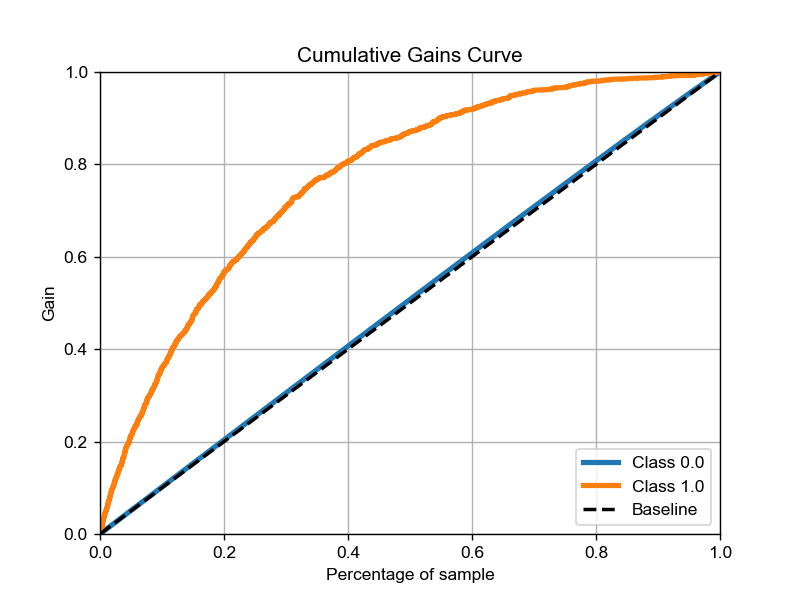

<IPython.core.display.Javascript object>


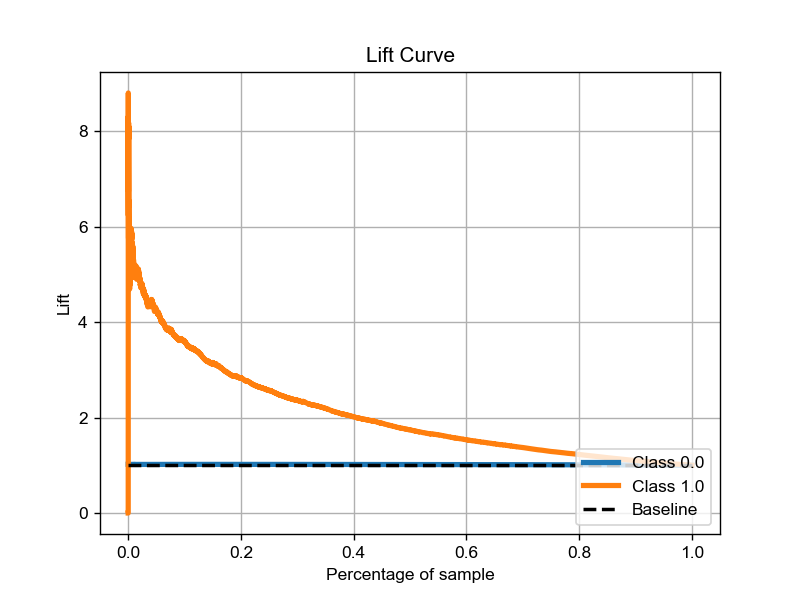

In [16]:
Y_test_pred_ = VotingClassifier.predict_proba(X_test)[:]
skplt.metrics.plot_cumulative_gain(Y_test, Y_test_pred_)
plt.show()
skplt.metrics.plot_lift_curve(Y_test, Y_test_pred_)
plt.show()

In [17]:
X_test
X_test['TW'] = pd.to_datetime(tws_test)
X_test['BARRIO'] = barrios_test
X_test['Probabilidad'] = Y_test_pred_[:,1]
X_test['Prediccion_Accidente'] = (X_test['Probabilidad']>=0.5).astype(int)

filt = X_test['TW']== dt.datetime(2019,12,23,17)

In [18]:
X_test[filt][['TW','BARRIO','Probabilidad','Prediccion_Accidente']].sort_values(by = 'Probabilidad', ascending = False).reset_index(drop = True)

,TW,BARRIO,Probabilidad,Prediccion_Accidente
0,2019-12-23 17:00:00,villacarlota,0.713878,1
1,2019-12-23 17:00:00,manila,0.705976,1
2,2019-12-23 17:00:00,laaguacatala,0.641639,1
3,2019-12-23 17:00:00,elpoblado,0.639997,1
4,2019-12-23 17:00:00,castropol,0.578737,1
5,2019-12-23 17:00:00,barriocolombia,0.576401,1
6,2019-12-23 17:00:00,laflorida,0.522799,1
7,2019-12-23 17:00:00,patiobonito,0.522358,1
8,2019-12-23 17:00:00,santamariadelosangeles,0.475626,0
9,2019-12-23 17:00:00,eltesoro,0.416268,0


# ROC Plot

<IPython.core.display.Javascript object>


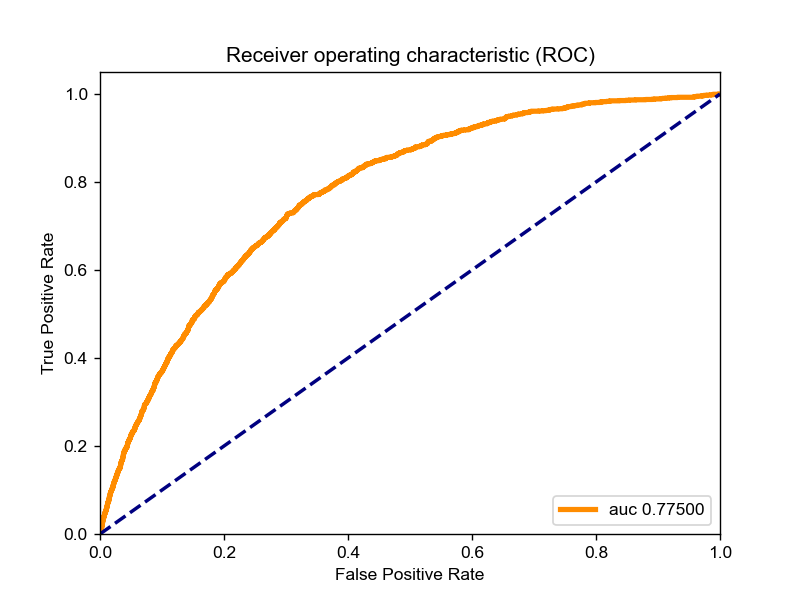

Text(0.5, 1.0, 'Receiver operating characteristic (ROC)')

In [19]:
fpr, tpr, _ = metrics.roc_curve(Y_test, proba[:,1], drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='darkorange', label=f'auc %0.5f' % roc_auc, lw = 3)    
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', lw = 2)
ax.legend(loc="lower right")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')    
ax.set_title('Receiver operating characteristic (ROC)')

# Precision Recall Plot

<IPython.core.display.Javascript object>


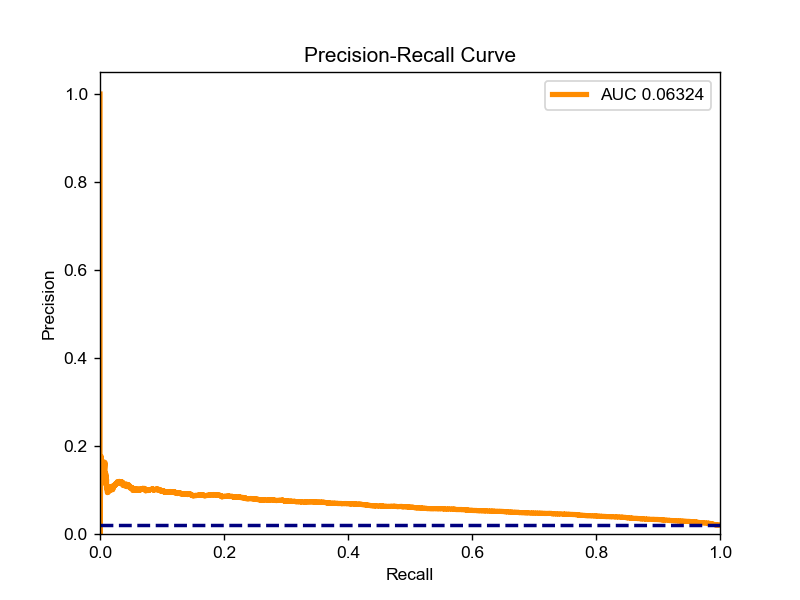

Text(0.5, 1.0, 'Precision-Recall Curve')

In [20]:
precision, recall, _ = metrics.precision_recall_curve(Y_test, proba[:,1])

auc = metrics.auc(recall, precision)

fig, ax = plt.subplots()

random = Y_test.sum()/len(Y_test)
ax.plot(recall, precision, color='darkorange', label=f'AUC %0.5f' % auc, lw = 3)    
ax.plot([0, 1], [random, random], color='navy', linestyle='--', lw = 2)
ax.legend(loc="upper right")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')    
ax.set_title('Precision-Recall Curve')

<IPython.core.display.Javascript object>


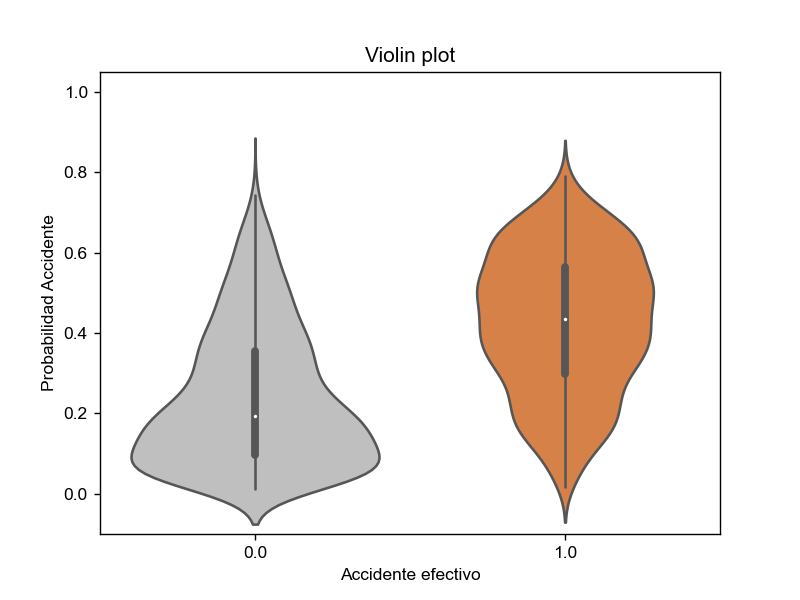

Text(0, 0.5, 'Probabilidad Accidente')

In [21]:
fig, ax = plt.subplots()

my_pal = {"0": "g", "1": "b"}
sns.set_style("whitegrid")
sns.violinplot(x = Y_test, y = proba[:,1], bw = 0.25, ax = ax,
               palette = [(191/255.0,191/255.0,191/255.0),(237/255.0,124/255.0,49/255.0)], showmeans = True, showmedians=True,
               showextrema=True)    
ax.set_title("Violin plot")
ax.set_ylim([-0.10, 1.05])
ax.set_xlabel("Accidente efectivo")
ax.set_ylabel("Probabilidad Accidente")